### <font color='#FF93D5'> [0] <u>Initialization</u> </font>

In [2]:
# remove residues from notebook
!rm -rf sample_data

# get the zip containing the cat images
!wget https://github.com/Crash285github/nyaural_catwork/raw/main/data/cats.zip -P data/

# extract the cats into data/
from zipfile import ZipFile
with ZipFile('data/cats.zip', 'r') as cats:
  cats.extractall('data')

# remove the downloaded zip
!rm data/cats.zip

'rm' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


### <font color='#FF7580'>[1] <u>Data manipulation</u> </font>

#### <font color='#777'> [1.0] Imports, parameters</font>

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as tforms
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
%matplotlib inline

# how to divide the dataset later on
train_frac, val_frac, test_frac = 7, 2, 1

# run the training on cuda gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### <font color='#C45A63'> [1.1] Dataset class</font>

In [4]:
class CatDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = []

        for img in os.listdir(main_dir):
            if not img.endswith(".jpg"):
                continue
            img_loc = os.path.join(self.main_dir, img)
            image = Image.open(img_loc).convert('RGB')
            tensor_image = self.transform(image)
            self.total_imgs.append(tensor_image)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        return self.total_imgs[idx]

#### <font color='#C45A63'>[1.2] Dataset details</font>

In [5]:
# image transformations
transforms = tforms.Compose([
  tforms.ToTensor(),
  tforms.Grayscale()
])

# normalize divisions
n_train_frac = train_frac / (train_frac + val_frac + test_frac)
n_val_frac = val_frac / (train_frac + val_frac + test_frac)
n_test_frac = test_frac / (train_frac + val_frac + test_frac)

print(f'{(n_train_frac*100):.1f} % Training data')
print(f'{(n_val_frac*100):.1f} % Validation data')
print(f'{(n_test_frac*100):.1f} % Testing data')

70.0 % Training data
20.0 % Validation data
10.0 % Testing data


#### <font color='#C45A63'>[1.3] Create Datasets</font>

In [6]:
# create the dataset
dataset = CatDataset('data', transforms)

# split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train_frac, n_val_frac, n_test_frac])

print(f'{len(train_dataset)}\ttraining images')
print(f'{len(val_dataset)}\tvalidating images')
print(f'{len(test_dataset)}\ttesting images')

11023	training images
3150	validating images
1574	testing images


##### <font color='#777'>[1.3.1] Visualize Datasets </font>

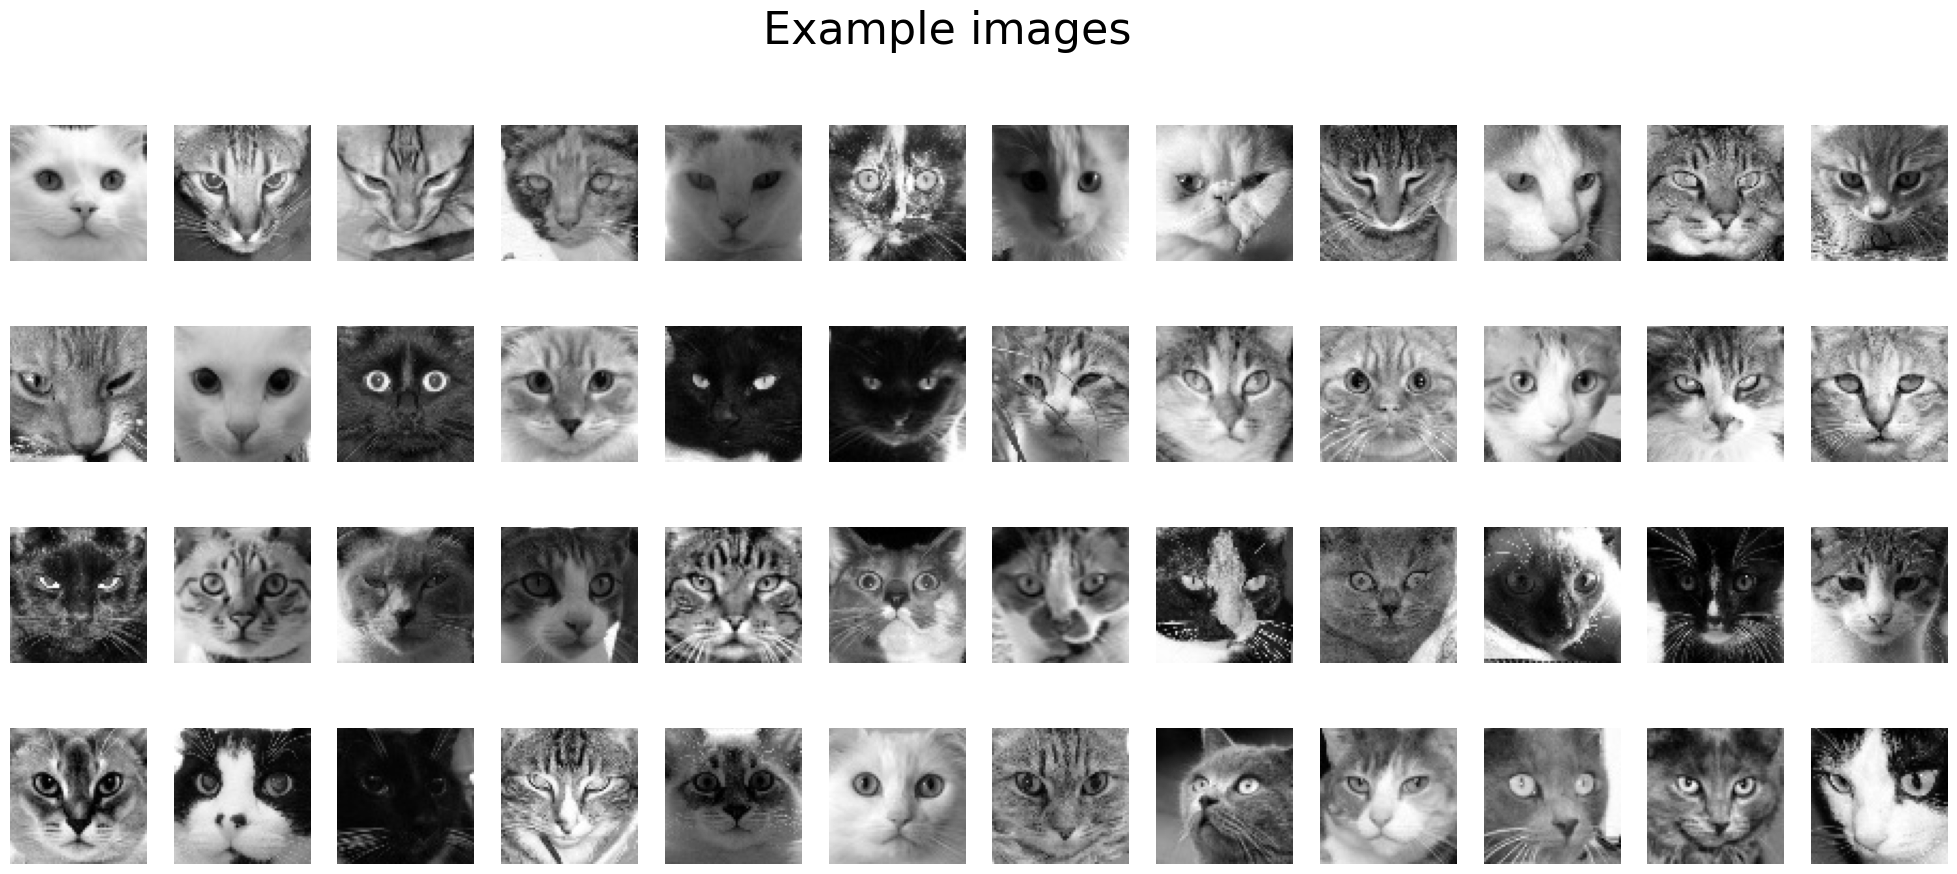

In [7]:
# how many images to show
number_of_sample_rows = 4
number_of_sample_cols = 12

fig, axs = plt.subplots(number_of_sample_rows, number_of_sample_cols, figsize=(number_of_sample_cols*2+1,number_of_sample_rows*2+2))
fig.suptitle("Example images", fontsize=32)

selected = np.random.choice(len(dataset), number_of_sample_cols * number_of_sample_rows, False)
for ind, ax in zip(selected, axs.flatten()):
    # we permute: (?, 64, 64) --> (64, 64, ?)
    ax.imshow(dataset[ind].permute(1,2,0), cmap='gray')
    ax.axis('off')



#### <font color='#C45A63'>[1.4] Create DataLoaders </font>

In [8]:
batch_size=24

# training loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# validation loader
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# testing loader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### <font color='#FFEC72'>[2] <u>Define Classes</u> </font>

#### <font color='#CEBD5C'> [2.1] Dense AutoEncoder</font>

In [9]:
class DenseAutoEncoder(nn.Module):
  def __init__(self):
    super(DenseAutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Flatten(), # (N, 64, 64) --> (N, 4096)
      nn.Linear(64**2, 48**2), # (N, 4096) --> (N, 256)
      nn.ReLU(),
      nn.Linear(48**2, 32**2),
      nn.ReLU(),
      nn.Linear(32**2, 16**2),
      nn.ReLU(),
      nn.Linear(16**2, 8**2),
    )

    self.decoder = nn.Sequential(
      nn.Linear(8**2, 16**2),
      nn.ReLU(),
      nn.Linear(16**2, 32**2),
      nn.ReLU(),
      nn.Linear(32**2, 48**2),
      nn.ReLU(),
      nn.Linear(48**2, 64**2),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded.reshape(-1,1,64,64)

  def regularization(self):
    return 0 # weight_decay is in optimizer

#### <font color='#CEBD5C'> [2.2] Sparse AutoEncoder</font>

In [10]:
class SparseAutoEncoder(nn.Module):
  def __init__(self, l1_lam=0.001):
    super(SparseAutoEncoder, self).__init__()
    self.l1_lam  = l1_lam
    self.encoder = nn.Sequential(
      nn.Flatten(), # (N, 64, 64) --> (N, 4096)
      nn.Linear(64**2, 48**2), # (N, 4096) --> (N, 256)
      nn.ReLU(),
      nn.Linear(48**2, 32**2),
    )

    self.decoder = nn.Sequential(
      nn.Linear(32**2, 48**2),
      nn.ReLU(),
      nn.Linear(48**2, 64**2),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded.reshape(-1,1,64,64)

  def regularization(self):
    l1_norm = sum(torch.linalg.norm(p, 1) for p in self.parameters())
    return self.l1_lam * l1_norm


#### <font color='#CEBD5C'> [2.3] EarlyStopper</font>

In [11]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0., model: nn.Module | None = None):
        self.patience: int = patience
        self.min_delta: float = min_delta
        self.counter: int = 0
        self.min_validation_loss: float = np.inf
        self.__model: nn.Module | None = model
        self.__state_dict = None

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            if self.__model is not None:
                self.__state_dict = deepcopy(self.__model.state_dict())
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def load_checkpoint(self):
        if self.__model is not None and self.__state_dict is not None:
            with torch.no_grad():
                self.__model.load_state_dict(self.__state_dict)


### <font color='#77FF5B'>[3] <u>Training Loop</u> </font>

#### <font color='#5EAA4C'> [3.1] Training, evaluation & testing functions</font>

In [12]:
def train_one_epoch(model, optimizer, data_loader, criterion):
  model.train()
  losses = []
  for i, image in enumerate(data_loader):
    print(f'\r Training:\t{(i*100 / len(data_loader)):.1f}%', end='')
    image = image.to(device)

    # forward pass
    reconstructed_image = model(image)
    loss = criterion(reconstructed_image, image) + model.regularization()

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
  print('\r Training:\t100.0%', end='')
  return np.mean(losses)

def test_model(model, data_loader, criterion, phase):
  model.eval()
  losses = []
  with torch.no_grad():
    for i, image in enumerate(data_loader):
      print(f'\r {phase}:\t{(i*100 / len(data_loader)):.1f}%', end='')
      image = image.to(device)

      # forward pass
      reconstructed_image = model(image)
      loss = criterion(reconstructed_image, image) + model.regularization()

      losses.append(loss.item())
    print(f'\r {phase}:\t100.0%', end='')
    return np.mean(losses)


#### <font color='#5EAA4C'> [3.2] Train DenseAutoEncoder</font>

In [13]:
# Dense model
dense_model = DenseAutoEncoder().to(device)
dense_criterion = nn.MSELoss()
dense_optimizer = optim.Adam(dense_model.parameters(), lr=0.0001, weight_decay=0.0001)

early_stopper = EarlyStopper(model=dense_model, patience=10)
for epoch in range(1000):
  print(f'Epoch {epoch+1}:')

  train_loss = train_one_epoch(dense_model, dense_optimizer, train_dataloader, dense_criterion)
  print(f' | loss: {train_loss:.4f}')

  val_loss = test_model(dense_model, val_dataloader, dense_criterion, phase='Validating')
  print(f' | loss: {val_loss:.4f}')

  test_loss = test_model(dense_model, test_dataloader, dense_criterion, phase='Testing')
  print(f' | loss: {test_loss:.4f}')

  print('=' * 20)

  if early_stopper(val_loss):
    print("Early stopped")
    early_stopper.load_checkpoint()
    break

Epoch 1:
 Training:	100.0% | loss: 0.0436
 Validating:	100.0% | loss: 0.0336
 Testing:	100.0% | loss: 0.0335
Epoch 2:
 Training:	100.0% | loss: 0.0331
 Validating:	100.0% | loss: 0.0319
 Testing:	100.0% | loss: 0.0320
Epoch 3:
 Training:	100.0% | loss: 0.0283
 Validating:	100.0% | loss: 0.0282
 Testing:	100.0% | loss: 0.0282
Epoch 4:
 Training:	100.0% | loss: 0.0277
 Validating:	100.0% | loss: 0.0281
 Testing:	100.0% | loss: 0.0280
Epoch 5:
 Training:	100.0% | loss: 0.0276
 Validating:	100.0% | loss: 0.0282
 Testing:	100.0% | loss: 0.0281
Epoch 6:
 Training:	100.0% | loss: 0.0276
 Validating:	100.0% | loss: 0.0281
 Testing:	100.0% | loss: 0.0280
Epoch 7:
 Training:	100.0% | loss: 0.0275
 Validating:	100.0% | loss: 0.0277
 Testing:	100.0% | loss: 0.0276
Epoch 8:
 Training:	100.0% | loss: 0.0274
 Validating:	100.0% | loss: 0.0276
 Testing:	100.0% | loss: 0.0276
Epoch 9:
 Training:	100.0% | loss: 0.0273
 Validating:	100.0% | loss: 0.0275
 Testing:	100.0% | loss: 0.0275
Epoch 10:
 Training

#### <font color='#5EAA4C'> [3.3] Train SparseAutoEncoder</font>

In [14]:
# Sparse model
sparse_model = SparseAutoEncoder(l1_lam=0.0006).to(device)
sparse_criterion = nn.MSELoss()
sparse_optimizer = optim.Adam(sparse_model.parameters(), lr=0.00014)

early_stopper = EarlyStopper(model=sparse_model, patience=5)
for epoch in range(1000):
  print(f'Epoch {epoch+1}:')

  train_loss = train_one_epoch(sparse_model, sparse_optimizer, train_dataloader, sparse_criterion)
  l1_to_loss_percentage = (sparse_model.regularization() / train_loss *100)
  print(f'\t| loss: {train_loss:.4f}, l1: {sparse_model.regularization():.4f} ({l1_to_loss_percentage:.0f}%)')

  prev_val_loss = val_loss
  val_loss = test_model(sparse_model, val_dataloader, sparse_criterion, phase='Validating')
  print(f'\t| loss: {val_loss:.4f}')

  test_loss = test_model(sparse_model, test_dataloader, sparse_criterion, phase='Testing')
  print(f'\t| loss: {test_loss:.4f}')

  print('=' * 20)

  if early_stopper(val_loss):
    print("Early stopped")
    early_stopper.load_checkpoint()
    break

Epoch 1:
 Training:	100.0%	| loss: 0.0976, l1: 0.0658 (67%)
 Validating:	100.0%	| loss: 0.0810
 Testing:	100.0%	| loss: 0.0810
Epoch 2:
 Training:	100.0%	| loss: 0.0789, l1: 0.0656 (83%)
 Validating:	100.0%	| loss: 0.0777
 Testing:	100.0%	| loss: 0.0778
Epoch 3:
 Training:	100.0%	| loss: 0.0755, l1: 0.0628 (83%)
 Validating:	100.0%	| loss: 0.0737
 Testing:	100.0%	| loss: 0.0737
Epoch 4:
 Training:	100.0%	| loss: 0.0725, l1: 0.0616 (85%)
 Validating:	100.0%	| loss: 0.0718
 Testing:	100.0%	| loss: 0.0719
Epoch 5:
 Training:	100.0%	| loss: 0.0703, l1: 0.0584 (83%)
 Validating:	100.0%	| loss: 0.0681
 Testing:	100.0%	| loss: 0.0682
Epoch 6:
 Training:	100.0%	| loss: 0.0648, l1: 0.0534 (82%)
 Validating:	100.0%	| loss: 0.0629
 Testing:	100.0%	| loss: 0.0629
Epoch 7:
 Training:	100.0%	| loss: 0.0612, l1: 0.0504 (82%)
 Validating:	100.0%	| loss: 0.0596
 Testing:	100.0%	| loss: 0.0596
Epoch 8:
 Training:	100.0%	| loss: 0.0579, l1: 0.0479 (83%)
 Validating:	100.0%	| loss: 0.0569
 Testing:	100.0%

#### <font color='#5EAA4C'> [3.3] Visualize original and reconstructed images</font>

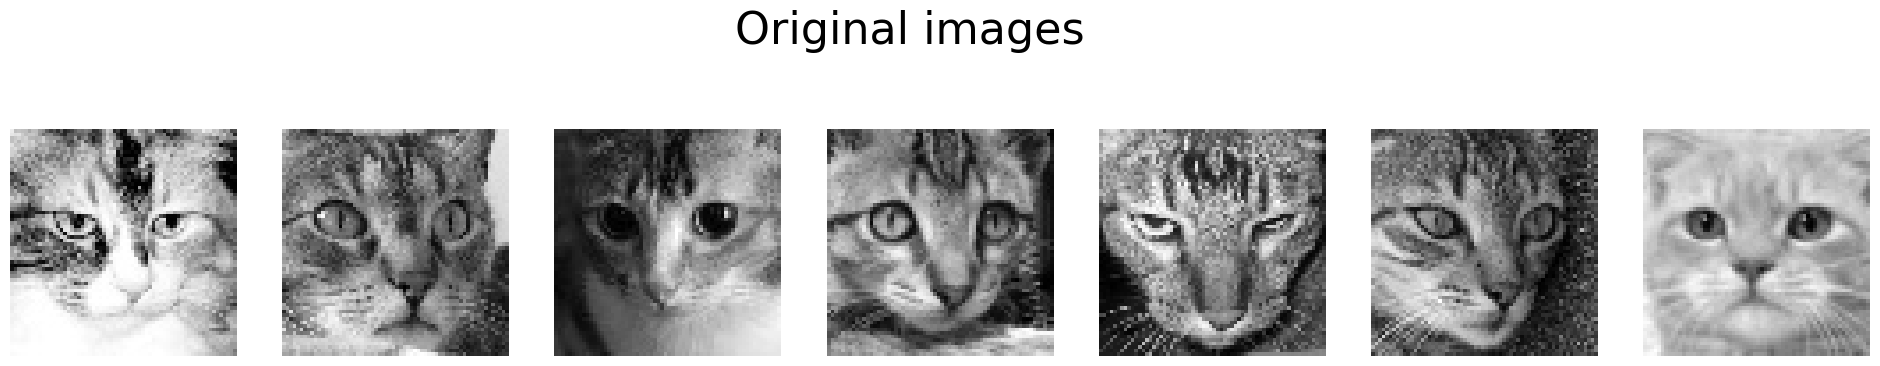

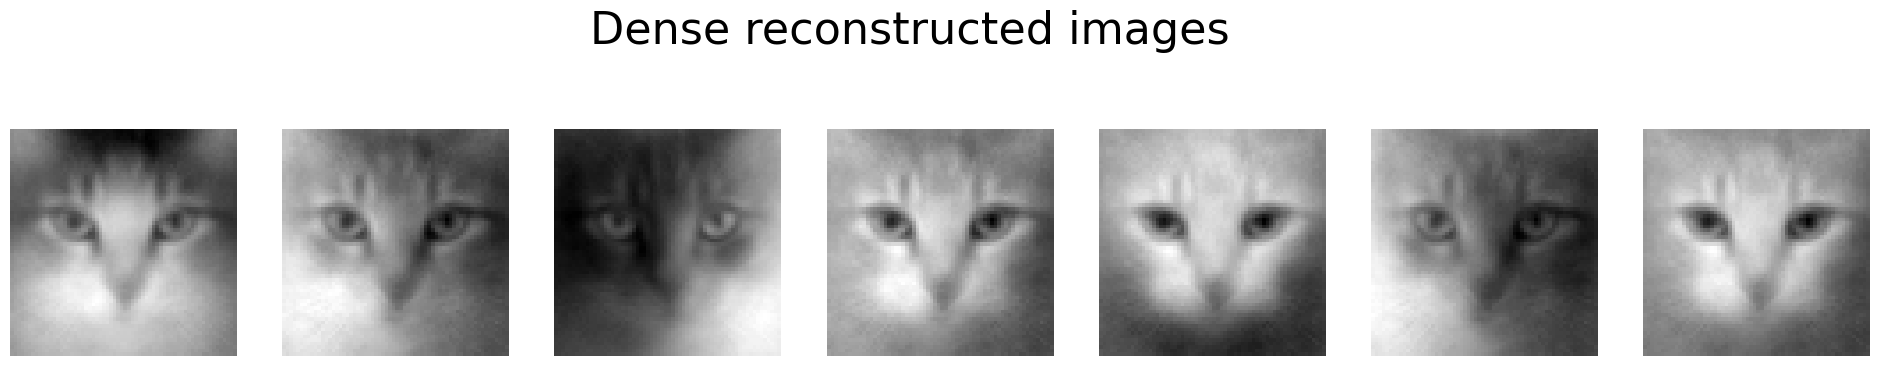

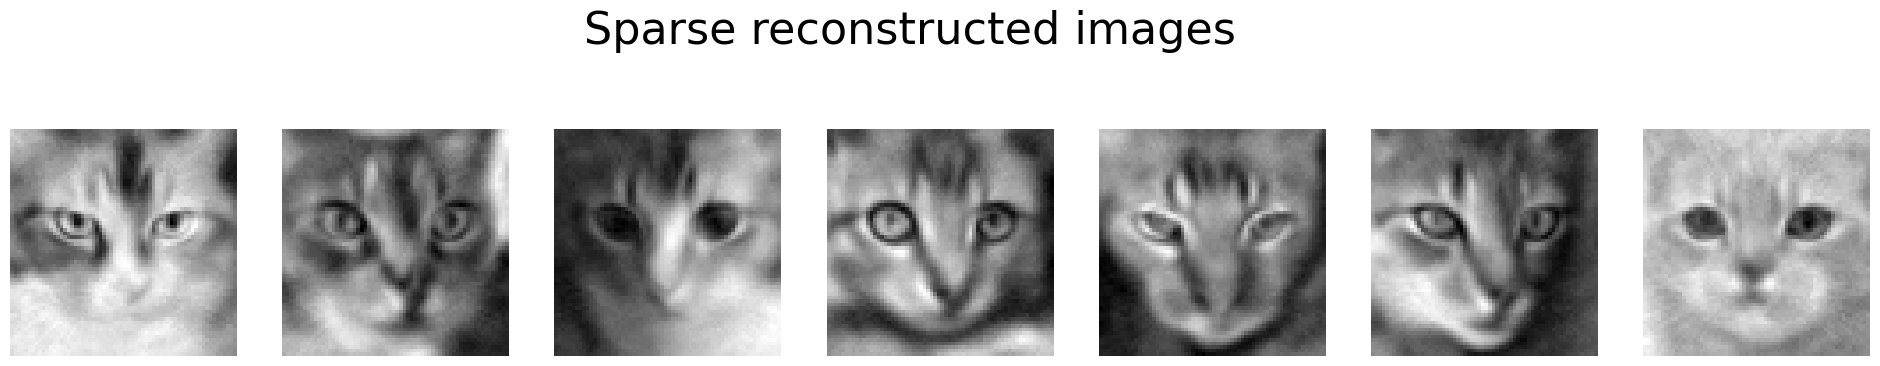

In [15]:
number_of_samples = 7

dense_model.eval()
sparse_model.eval()

selected = np.random.choice(len(test_dataset), number_of_samples, False)
selected_tests = [test_dataset[i] for i in selected]

# Original images
fig, axs = plt.subplots(1, number_of_samples)
fig.set_figwidth(24)
fig.suptitle("Original images", fontsize=32)
for image, ax in zip(selected_tests, axs.flatten()):
    ax.imshow(image.permute(1,2,0), cmap='gray')
    ax.axis('off')

with torch.no_grad():
  # Dense model reconstructed images
  fig, axs = plt.subplots(1, number_of_samples)
  fig.set_figwidth(24)
  fig.suptitle("Dense reconstructed images", fontsize=32)
  for image, ax in zip(selected_tests, axs):
      reconstructed_image = dense_model(image.to(device)).to('cpu').detach().reshape(-1,64,64)
      ax.imshow(reconstructed_image.permute(1,2,0), cmap='gray')
      ax.axis('off')

  # Sparse model reconstructed images
  fig, axs = plt.subplots(1, number_of_samples)
  fig.set_figwidth(24)
  fig.suptitle("Sparse reconstructed images", fontsize=32)
  for image, ax in zip(selected_tests, axs):
      reconstructed_image = sparse_model(image.to(device)).to('cpu').detach().reshape(-1,64,64)
      ax.imshow(reconstructed_image.permute(1,2,0), cmap='gray')
      ax.axis('off')

#### <font color='#5EAA4C'> [3.4] Visualize Sparse reprezentation</font>

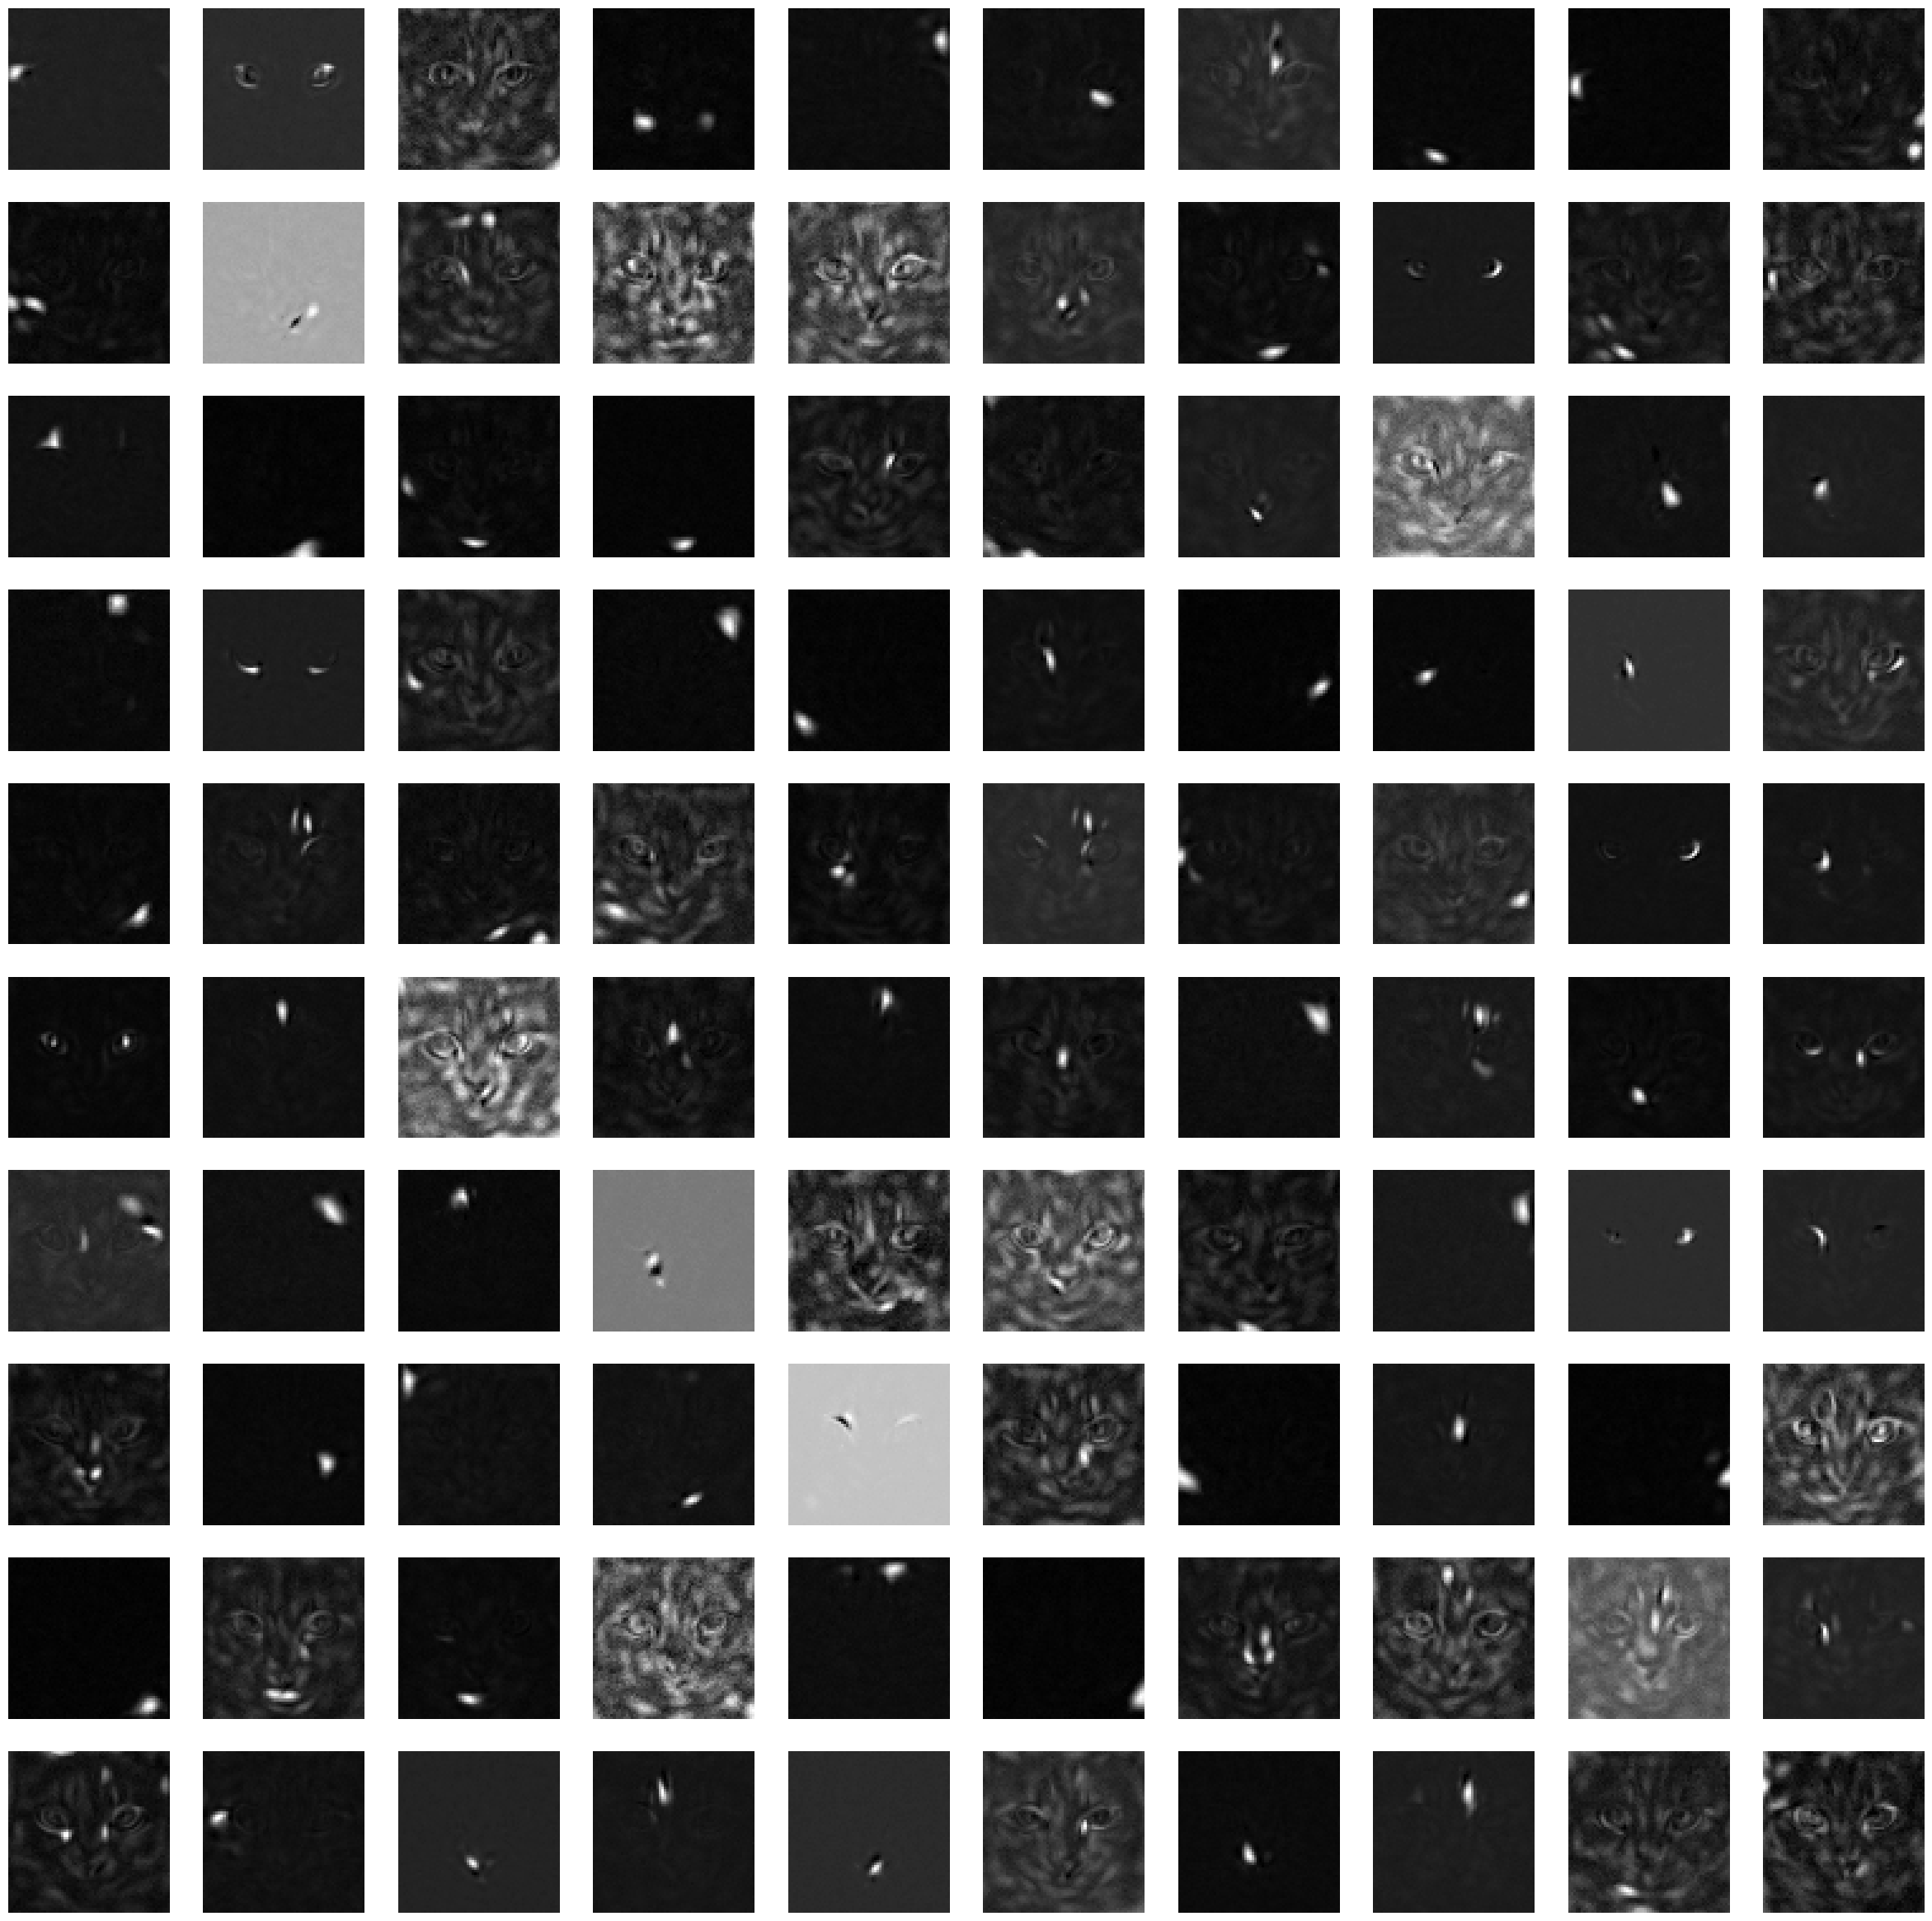

In [16]:
idxs = np.random.choice(np.arange(32**2), 100, False)
fig, axs = plt.subplots(10,10, figsize=(30,30))

with torch.no_grad():
  for i in range(10):
    for j in range(10):
      onehot = torch.zeros(32**2)
      onehot[idxs[10*i + j]] = 1
      out = sparse_model.decoder(onehot.to(device)).detach().cpu().numpy()
      out = out.reshape(1,64,64).transpose([1,2,0])
      axs[i,j].imshow(out, cmap='gray')
      axs[i,j].axis('off')
plt.show()

In [17]:
# done
try: 
    from google.colab import output
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
except:
    pass